In [22]:
!pip install torchsummary 

In [141]:
import urllib

import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from torchsummary import summary
from scipy.ndimage import zoom
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

torch.fx.wrap('len')  # Needed by create_feature_extractor function

'len'

In [16]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

--2023-10-14 07:02:48--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.1’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-10-14 07:02:48 (25.3 MB/s) - ‘imagenet_classes.txt.1’ saved [10472/10472]



In [53]:
# image_url = "https://media.baamboozle.com/uploads/images/193455/1618428104_154705.jpeg"
image_path = "cat.jpg"
# urllib.request.urlretrieve(image_url, image_path)

In [188]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.eval()
summary(model, input_batch.size()[1:], batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 112, 112]           9,408
       BatchNorm2d-2          [1, 64, 112, 112]             128
              ReLU-3          [1, 64, 112, 112]               0
         MaxPool2d-4            [1, 64, 56, 56]               0
            Conv2d-5            [1, 64, 56, 56]           4,096
       BatchNorm2d-6            [1, 64, 56, 56]             128
              ReLU-7            [1, 64, 56, 56]               0
            Conv2d-8            [1, 64, 56, 56]          36,864
       BatchNorm2d-9            [1, 64, 56, 56]             128
             ReLU-10            [1, 64, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]          16,384
      BatchNorm2d-12           [1, 256, 56, 56]             512
           Conv2d-13           [1, 256, 56, 56]          16,384
      BatchNorm2d-14           [1, 256,

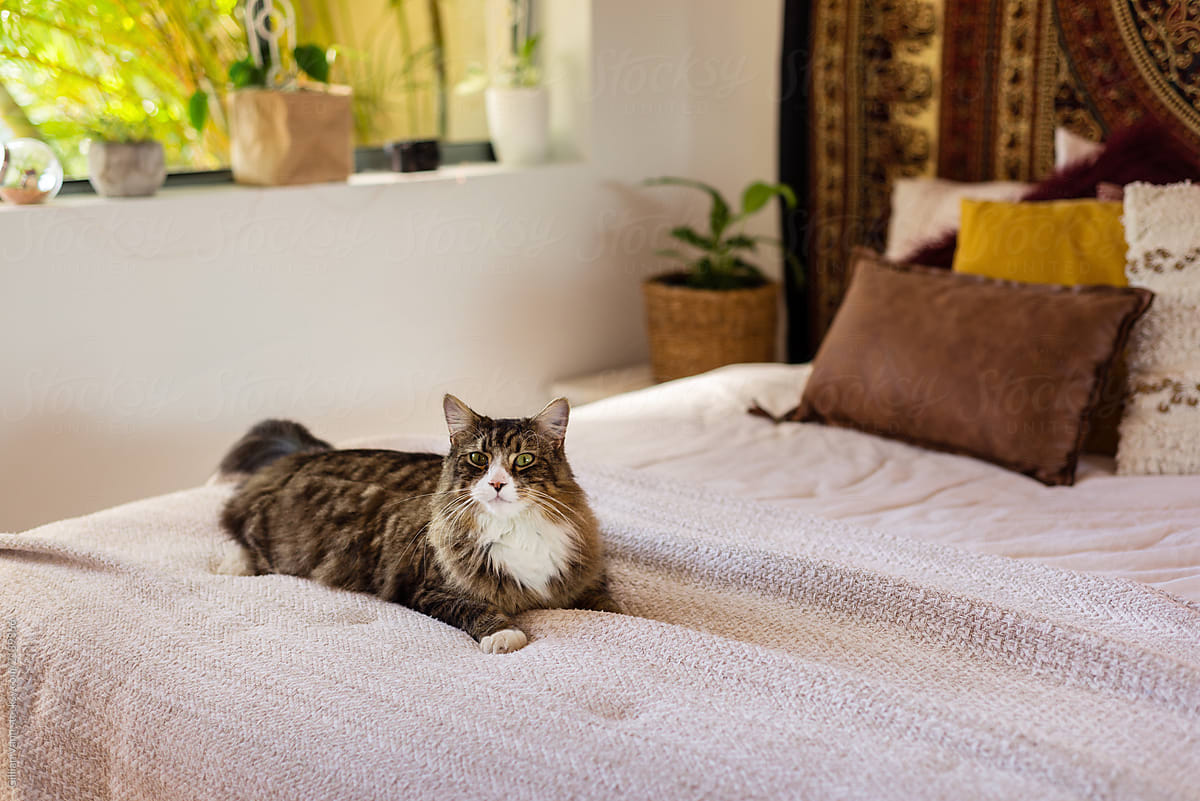

In [181]:
from PIL import Image
from torchvision import transforms
input_image = Image.open(image_path)

input_image

In [182]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

In [191]:
with torch.no_grad():
    output = model(input_batch)

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities.shape)

torch.Size([1000])


In [164]:
top_probs, top_catids = torch.topk(probabilities, 25)
for i in range(top5_prob.size(0)):
    print(top_catids[i], categories[top_catids[i]], top_probs[i].item())

tensor(750) quilt 0.21775111556053162
tensor(281) tabby 0.0763394832611084
tensor(285) Egyptian cat 0.04909980297088623
tensor(831) studio couch 0.046395279467105865
tensor(282) tiger cat 0.041201844811439514
tensor(876) tub 0.021044237539172173
tensor(811) space heater 0.010857390239834785
tensor(700) paper towel 0.00915656890720129
tensor(721) pillow 0.007744640577584505
tensor(532) dining table 0.006651123985648155
tensor(794) shower curtain 0.006288176868110895
tensor(722) ping-pong ball 0.005961799994111061
tensor(728) plastic bag 0.0059257857501506805
tensor(435) bathtub 0.004973717033863068
tensor(741) prayer rug 0.004744472913444042
tensor(564) four-poster 0.004026781301945448
tensor(753) radiator 0.0039015724323689938
tensor(797) sleeping bag 0.003635631874203682
tensor(905) window shade 0.0032662104349583387
tensor(673) mouse 0.0032153211068361998
tensor(761) remote control 0.0032076581846922636
tensor(851) television 0.003184001427143812
tensor(283) Persian cat 0.00314118876

In [169]:
def get_layer(name, model):
    for name_i, module_i in model.named_modules():
        if name_i == name:
            return module_i

In [184]:
def get_cam(model: nn.Module, input_batch, cls: int):
    # c: num_classes (1000 for imagenet) | f: num_feature_maps (2048 for the last layer before gap in ResNet50)
    # img_w: 224, img_h: 224 | feature_map_w: 7, feature_map_h: (7 for the last layer before gap in ResNet50)
    batch_size, img_w, img_h = input_batch.size(0), input_batch.size(2), input_batch.size(3)
    assert batch_size == 1, "I was too lazy to add the for loop for batch_size > 1"

    return_nodes = {
        "layer4.2.relu_2": "feature_maps"
    }
    feature_maps_model = create_feature_extractor(model, return_nodes=return_nodes)
    feature_maps_model_output = feature_maps_model(input_batch)
    feature_maps = feature_maps_model_output['feature_maps']

    all_cls_pred_layer_weights = get_layer('fc', model).weight  # torch.size([c, f])
    selected_cls_pred_layer_weights = all_cls_pred_layer_weights[cls] # torch.Size([f])
    selected_cls_pred_layer_weights = selected_cls_pred_layer_weights.view(batch_size, -1, 1, 1) #

    scaled_feature_maps = feature_maps * selected_cls_pred_layer_weights  # torch.size([batch_size, f, feature_map_w, feature_map_h])
    aggregated_feature_map = scaled_feature_maps.sum(dim=1)  # torch.size([batch_size, feature_map_w, feature_map_h])
    
    feature_map_w, feature_map_h = aggregated_feature_map.size(1), aggregated_feature_map.size(2)
    aggregated_feature_map = aggregated_feature_map.squeeze().detach().numpy()    

    cam = zoom(
        aggregated_feature_map,
        (img_w // feature_map_w, img_h // feature_map_h),
        order=2
    )
    return cam

In [202]:
def show_cam_for_class(class_idx):
    category = categories[class_idx]
    prob = probabilities[class_idx]
    cam = get_cam(model, input_batch, class_idx)
    
    input_image_np = input_tensor.numpy().transpose((1, 2, 0))
    input_image_np = np.clip(input_image_np, 0, 1)
    
    print(f'The model should be looking at the {category} (class {class_idx}) which has a probability of {prob}')
    
    plt.figure(figsize=(8,8))
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.imshow(input_image_np, alpha=0.5)
    plt.show()

The model should be looking at the quilt (class 750) which has a probability of 0.21775111556053162


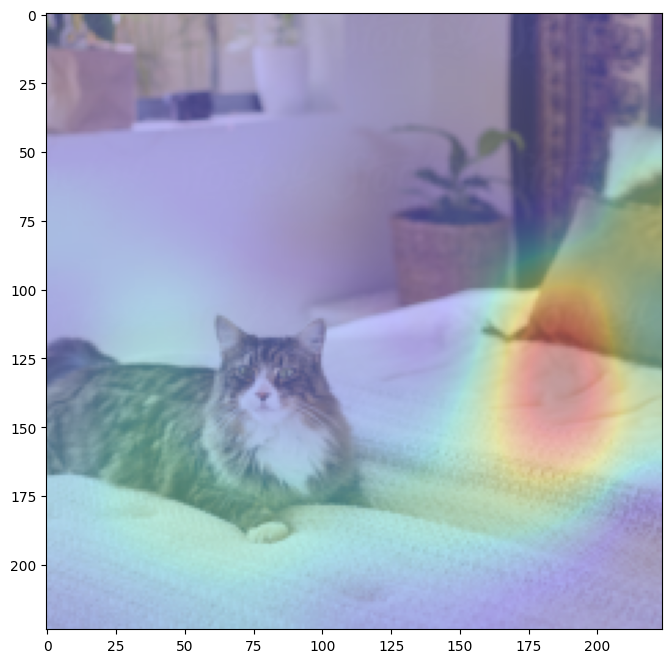

In [203]:
show_cam_for_class(750)

The model should be looking at the tabby (class 281) which has a probability of 0.0763394832611084


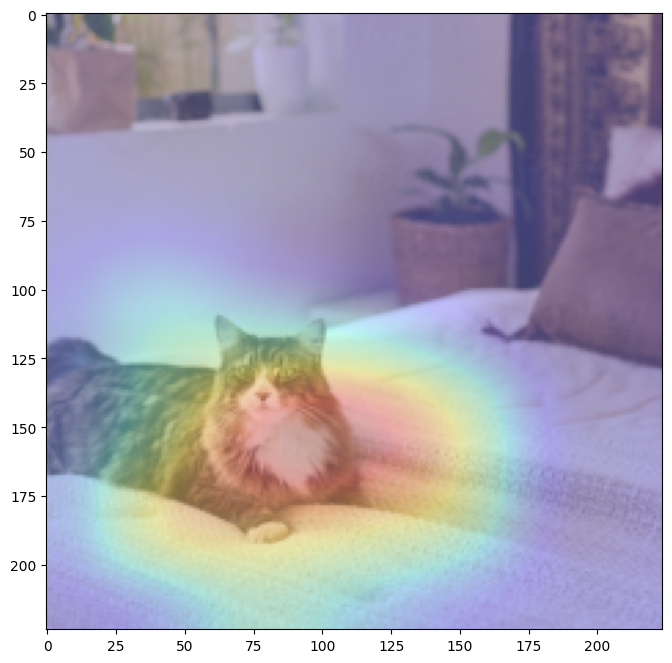

In [204]:
show_cam_for_class(281)

The model should be looking at the Egyptian cat (class 285) which has a probability of 0.04909980297088623


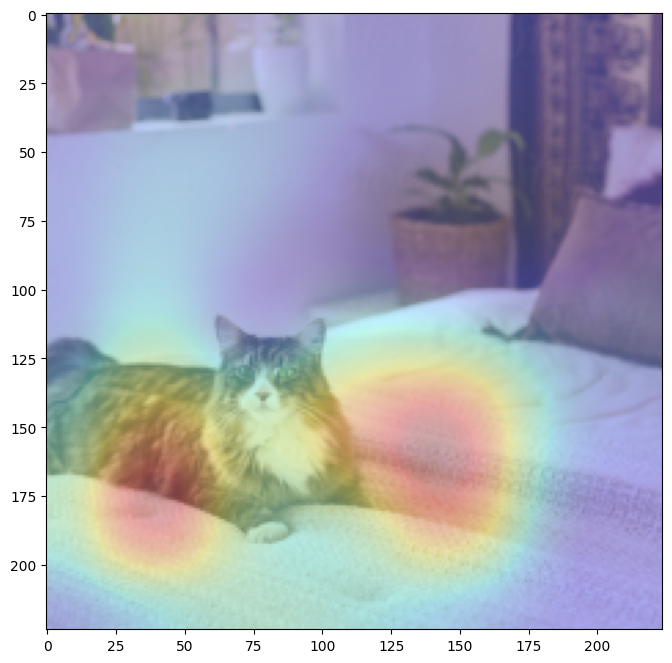

In [205]:
show_cam_for_class(285)

The model should be looking at the studio couch (class 831) which has a probability of 0.046395279467105865


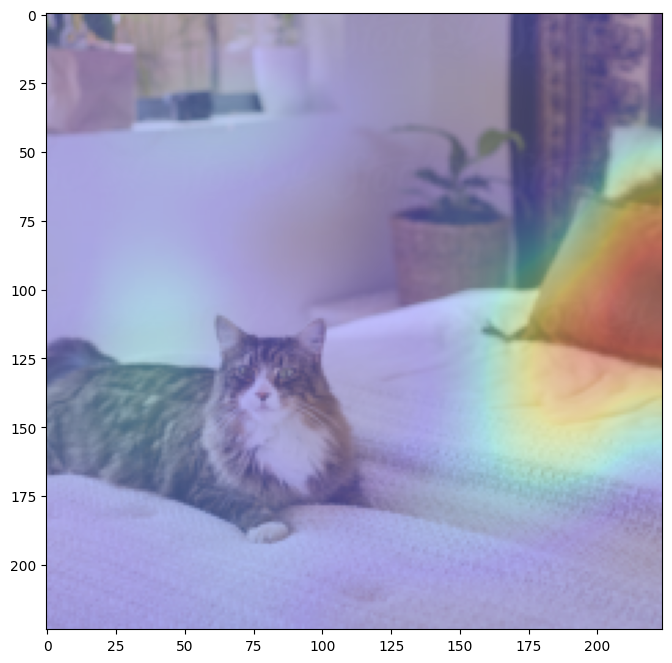

In [206]:
show_cam_for_class(831)

The model should be looking at the tiger cat (class 282) which has a probability of 0.041201844811439514


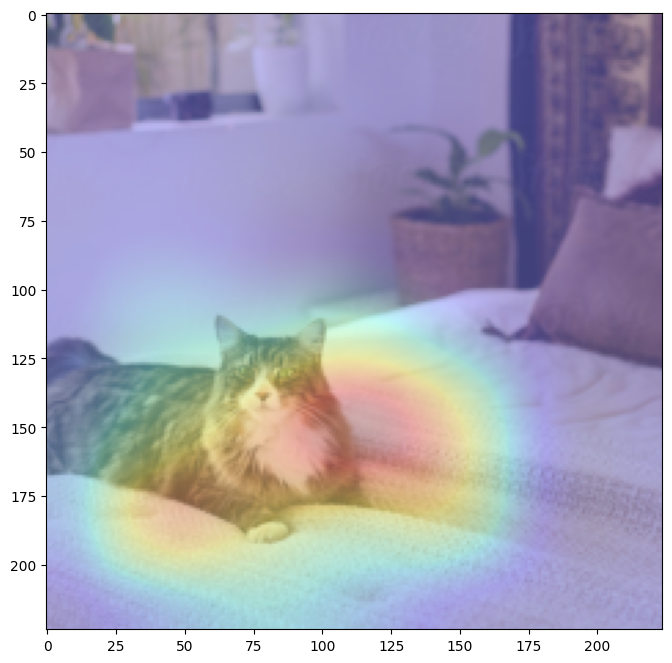

In [207]:
show_cam_for_class(282)

The model should be looking at the laptop (class 620) which has a probability of 0.0030478781554847956


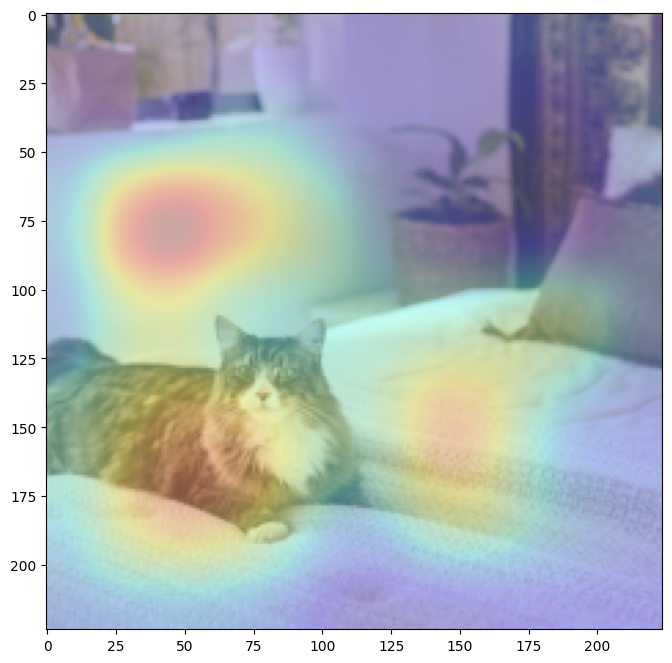

In [208]:
show_cam_for_class(620)